
- why for alpha=1.0 (in the code) the performance of ens and prod is not more or less the same for M=1 (i.e. ensembles of size 1)? the performance gap is actually the biggest for alpha=1, why??
- study magnitudes of terms in objective function (would imagine for that sum of expert likelihoods is larger compared to PoE likelihood), how does this impact the choice of alpha?
- stochastic sampling of ensemble members during training

DONE:
- plot effect of alpha and pretraining
- random seed in ensembles -> are we using different seeds for each member? YES

In [1]:
import os
import logging
from functools import partial

from jax import random
from torchvision import transforms
import wandb
from flax.training.checkpoints import save_checkpoint, restore_checkpoint

from src.models import make_Hard_OvR_Ens_loss as make_prod_loss
from src.models import make_Hard_OvR_Ens_MNIST_plots as make_plots
from src.models import make_Cls_Ens_loss as make_ens_loss
from src.data import get_image_dataset, NumpyLoader
from src.utils.training import setup_training, train_loop
from src.utils.notebook_metrics import *
from experiments.configs.mnist_hard_ovr_classification import get_config

from operator import itemgetter
from  functools import partial
from itertools import combinations

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from plotly.subplots import make_subplots
import plotly.graph_objects as go

2022-10-14 10:12:55.627807: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-14 10:12:56.591985: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-10-14 10:12:56.592088: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-10-14 10:12:56.592098: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [2]:
os.environ['XLA_FLAGS'] = "--xla_gpu_force_compilation_parallelism=1"

In [3]:
os.environ['WANDB_NOTEBOOK_NAME'] = 'mnist_performance_gap_investigation.ipynb'
# ^ W&B doesn't know how to handle VS Code notebooks.

wandb.login()

wandb: Currently logged in as: metodj. Use `wandb login --relogin` to force relogin


True

In [4]:
config = get_config()

In [5]:
ens_config = config.copy_and_resolve_references()
ens_config.model_name = 'Cls_Ens'
del ens_config.β_schedule

### 1) load datasets

In [6]:
train_dataset, _, val_dataset = get_image_dataset(
    dataset_name=config.dataset_name,
    val_percent=config.val_percent,
    flatten_img=True,
    train_augmentations=[
        # transforms.RandomCrop(28, padding=2),
        # transforms.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.95, 1.05), shear=5),
        # transforms.RandomHorizontalFlip(),
        # transforms.
    ]
)
ens_train_loader = NumpyLoader(train_dataset, config.batch_size, num_workers=8)
ens_val_loader = NumpyLoader(val_dataset, config.batch_size, num_workers=8)

train_dataset, test_dataset, val_dataset = get_image_dataset(
    dataset_name=config.dataset_name,
    val_percent=config.val_percent,
    flatten_img=True,
    train_augmentations=[
        # transforms.RandomCrop(28, padding=2),
        # transforms.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.95, 1.05), shear=5),
        # transforms.RandomHorizontalFlip(),
        # transforms.
    ]
)
train_loader = NumpyLoader(train_dataset, config.batch_size, num_workers=8)
val_loader = NumpyLoader(val_dataset, config.batch_size, num_workers=8)
test_loader = NumpyLoader(test_dataset, config.batch_size, num_workers=8)

In [7]:
print(ens_config)

batch_size: 512
dataset_name: MNIST
epochs: 50
learning_rate: 0.003
lr_schedule:
  decay_steps: 5300
  end_value: 0.00030000000000000003
  peak_value: 0.009000000000000001
  warmup_steps: 1060
lr_schedule_name: warmup_cosine_decay_schedule
model:
  learn_weights: false
  net:
    depth: 5
    hidden_size: 200
    out_size: 10
    p_drop: 0.1
  size: 5
model_name: Cls_Ens
optim:
  momentum: 0.9
  weight_decay: 0.0001
optim_name: sgdw
val_percent: 0.1



### 2) model training

In [9]:
RANDOM_SEEDS = [0]
ALPHAS = [0., 0.2, 0.4, 0.5, 0.6, 0.8 ,1.]
RECOMPUTE_ENS = True

for i in RANDOM_SEEDS:
    rng = random.PRNGKey(i)
    setup_rng, rng = random.split(rng)
    init_x = train_dataset[0][0]
    init_y = train_dataset[0][1]

    ens_model, state = setup_training(ens_config, setup_rng, init_x, init_y)

    if RECOMPUTE_ENS:
        _, ens_state = train_loop(
            ens_model, state, ens_config, rng, make_ens_loss, make_ens_loss, ens_train_loader, ens_val_loader,
            # test_loader,
            wandb_kwargs={
                'mode': 'online',
                # 'notes': 'Data augmentation',
                # 'tags': ['MNIST testing'],
            },
            # plot_fn=make_plots,
            # plot_freq=1,
        )

        save_checkpoint(f'dynNN_redux/ens_model_{i}', ens_state, 1, overwrite=True)

    rng = random.PRNGKey(i)
    setup_rng, rng = random.split(rng)
    
    for alpha in ALPHAS:
        # for pretrained in [False, True]:
        for pretrained in [True]:
            
            prod_model, state = setup_training(config, setup_rng, init_x, init_y)
            config.alpha = alpha
            config.pretrained = pretrained

            if pretrained:
                state = state.replace(params=ens_state.params)

            _, prod_state = train_loop(
                    prod_model, state, config, rng, 
                partial(make_prod_loss, per_member_loss=alpha), 
                partial(make_prod_loss, per_member_loss=alpha), 
                train_loader, val_loader,
                # test_loader,
                wandb_kwargs={
                    'mode': 'online',
                    # 'notes': 'pre-trained',
                    # 'tags': ['MNIST testing', 'pre-trained'],
                },
                # plot_fn=make_plots,
                # plot_freq=1,
            )
            
            pretrained = "_pretrained" if pretrained else ""
            save_checkpoint(f'dynNN_redux/prod_model_{i}_{alpha}{pretrained}', prod_state, 1, overwrite=True)

+---------------------------------------------+------------+---------+-----------+--------+
| Name                                        | Shape      | Size    | Mean      | Std    |
+---------------------------------------------+------------+---------+-----------+--------+
| batch_stats/nets_0/layer_0/BatchNorm_0/mean | (200,)     | 200     | 0.0       | 0.0    |
| batch_stats/nets_0/layer_0/BatchNorm_0/var  | (200,)     | 200     | 1.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/mean | (200,)     | 200     | 0.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/var  | (200,)     | 200     | 1.0       | 0.0    |
| batch_stats/nets_0/layer_2/BatchNorm_0/mean | (200,)     | 200     | 0.0       | 0.0    |
| batch_stats/nets_0/layer_2/BatchNorm_0/var  | (200,)     | 200     | 1.0       | 0.0    |
| batch_stats/nets_0/layer_3/BatchNorm_0/mean | (200,)     | 200     | 0.0       | 0.0    |
| batch_stats/nets_0/layer_3/BatchNorm_0/var  | (200,)     | 200     | 1.0      

+---------------------------------------------+------------+---------+-----------+--------+
| Name                                        | Shape      | Size    | Mean      | Std    |
+---------------------------------------------+------------+---------+-----------+--------+
| batch_stats/nets_0/layer_0/BatchNorm_0/mean | (200,)     | 200     | 0.0       | 0.0    |
| batch_stats/nets_0/layer_0/BatchNorm_0/var  | (200,)     | 200     | 1.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/mean | (200,)     | 200     | 0.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/var  | (200,)     | 200     | 1.0       | 0.0    |
| batch_stats/nets_0/layer_2/BatchNorm_0/mean | (200,)     | 200     | 0.0       | 0.0    |
| batch_stats/nets_0/layer_2/BatchNorm_0/var  | (200,)     | 200     | 1.0       | 0.0    |
| batch_stats/nets_0/layer_3/BatchNorm_0/mean | (200,)     | 200     | 0.0       | 0.0    |
| batch_stats/nets_0/layer_3/BatchNorm_0/var  | (200,)     | 200     | 1.0      

+---------------------------------------------+------------+---------+-----------+--------+
| Name                                        | Shape      | Size    | Mean      | Std    |
+---------------------------------------------+------------+---------+-----------+--------+
| batch_stats/nets_0/layer_0/BatchNorm_0/mean | (200,)     | 200     | 0.0       | 0.0    |
| batch_stats/nets_0/layer_0/BatchNorm_0/var  | (200,)     | 200     | 1.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/mean | (200,)     | 200     | 0.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/var  | (200,)     | 200     | 1.0       | 0.0    |
| batch_stats/nets_0/layer_2/BatchNorm_0/mean | (200,)     | 200     | 0.0       | 0.0    |
| batch_stats/nets_0/layer_2/BatchNorm_0/var  | (200,)     | 200     | 1.0       | 0.0    |
| batch_stats/nets_0/layer_3/BatchNorm_0/mean | (200,)     | 200     | 0.0       | 0.0    |
| batch_stats/nets_0/layer_3/BatchNorm_0/var  | (200,)     | 200     | 1.0      

+---------------------------------------------+------------+---------+-----------+--------+
| Name                                        | Shape      | Size    | Mean      | Std    |
+---------------------------------------------+------------+---------+-----------+--------+
| batch_stats/nets_0/layer_0/BatchNorm_0/mean | (200,)     | 200     | 0.0       | 0.0    |
| batch_stats/nets_0/layer_0/BatchNorm_0/var  | (200,)     | 200     | 1.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/mean | (200,)     | 200     | 0.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/var  | (200,)     | 200     | 1.0       | 0.0    |
| batch_stats/nets_0/layer_2/BatchNorm_0/mean | (200,)     | 200     | 0.0       | 0.0    |
| batch_stats/nets_0/layer_2/BatchNorm_0/var  | (200,)     | 200     | 1.0       | 0.0    |
| batch_stats/nets_0/layer_3/BatchNorm_0/mean | (200,)     | 200     | 0.0       | 0.0    |
| batch_stats/nets_0/layer_3/BatchNorm_0/var  | (200,)     | 200     | 1.0      

+---------------------------------------------+------------+---------+-----------+--------+
| Name                                        | Shape      | Size    | Mean      | Std    |
+---------------------------------------------+------------+---------+-----------+--------+
| batch_stats/nets_0/layer_0/BatchNorm_0/mean | (200,)     | 200     | 0.0       | 0.0    |
| batch_stats/nets_0/layer_0/BatchNorm_0/var  | (200,)     | 200     | 1.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/mean | (200,)     | 200     | 0.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/var  | (200,)     | 200     | 1.0       | 0.0    |
| batch_stats/nets_0/layer_2/BatchNorm_0/mean | (200,)     | 200     | 0.0       | 0.0    |
| batch_stats/nets_0/layer_2/BatchNorm_0/var  | (200,)     | 200     | 1.0       | 0.0    |
| batch_stats/nets_0/layer_3/BatchNorm_0/mean | (200,)     | 200     | 0.0       | 0.0    |
| batch_stats/nets_0/layer_3/BatchNorm_0/var  | (200,)     | 200     | 1.0      

+---------------------------------------------+------------+---------+-----------+--------+
| Name                                        | Shape      | Size    | Mean      | Std    |
+---------------------------------------------+------------+---------+-----------+--------+
| batch_stats/nets_0/layer_0/BatchNorm_0/mean | (200,)     | 200     | 0.0       | 0.0    |
| batch_stats/nets_0/layer_0/BatchNorm_0/var  | (200,)     | 200     | 1.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/mean | (200,)     | 200     | 0.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/var  | (200,)     | 200     | 1.0       | 0.0    |
| batch_stats/nets_0/layer_2/BatchNorm_0/mean | (200,)     | 200     | 0.0       | 0.0    |
| batch_stats/nets_0/layer_2/BatchNorm_0/var  | (200,)     | 200     | 1.0       | 0.0    |
| batch_stats/nets_0/layer_3/BatchNorm_0/mean | (200,)     | 200     | 0.0       | 0.0    |
| batch_stats/nets_0/layer_3/BatchNorm_0/var  | (200,)     | 200     | 1.0      

+---------------------------------------------+------------+---------+-----------+--------+
| Name                                        | Shape      | Size    | Mean      | Std    |
+---------------------------------------------+------------+---------+-----------+--------+
| batch_stats/nets_0/layer_0/BatchNorm_0/mean | (200,)     | 200     | 0.0       | 0.0    |
| batch_stats/nets_0/layer_0/BatchNorm_0/var  | (200,)     | 200     | 1.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/mean | (200,)     | 200     | 0.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/var  | (200,)     | 200     | 1.0       | 0.0    |
| batch_stats/nets_0/layer_2/BatchNorm_0/mean | (200,)     | 200     | 0.0       | 0.0    |
| batch_stats/nets_0/layer_2/BatchNorm_0/var  | (200,)     | 200     | 1.0       | 0.0    |
| batch_stats/nets_0/layer_3/BatchNorm_0/mean | (200,)     | 200     | 0.0       | 0.0    |
| batch_stats/nets_0/layer_3/BatchNorm_0/var  | (200,)     | 200     | 1.0      

+---------------------------------------------+------------+---------+-----------+--------+
| Name                                        | Shape      | Size    | Mean      | Std    |
+---------------------------------------------+------------+---------+-----------+--------+
| batch_stats/nets_0/layer_0/BatchNorm_0/mean | (200,)     | 200     | 0.0       | 0.0    |
| batch_stats/nets_0/layer_0/BatchNorm_0/var  | (200,)     | 200     | 1.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/mean | (200,)     | 200     | 0.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/var  | (200,)     | 200     | 1.0       | 0.0    |
| batch_stats/nets_0/layer_2/BatchNorm_0/mean | (200,)     | 200     | 0.0       | 0.0    |
| batch_stats/nets_0/layer_2/BatchNorm_0/var  | (200,)     | 200     | 1.0       | 0.0    |
| batch_stats/nets_0/layer_3/BatchNorm_0/mean | (200,)     | 200     | 0.0       | 0.0    |
| batch_stats/nets_0/layer_3/BatchNorm_0/var  | (200,)     | 200     | 1.0      

### 3) metrics

In [10]:
results_df = pd.DataFrame(columns=['model_name', 'n_members', 'random_seed', 'H', 'err', 'brier', 'nll'])
results_df

,model_name,n_members,random_seed,H,err,brier,nll


In [11]:
s = set(range(config.model.size))
power_set = sum(map(lambda r: list(combinations(s, r)), range(1, len(s)+1)), [])

In [12]:
X_test, y_test = list(zip(*test_loader.dataset))

In [13]:
def compute_metrics(model, model_name, state, random_seed):
    pred_fun = partial(
            model.apply,
            {"params": state['params'], **state['model_state']},
            train=False,
            method=model.ens_logits
        )
    logits = jax.vmap(
        pred_fun, axis_name="batch"
    )(jnp.array(X_test))

    rows = []
    for indices in power_set:
        n_members = len(indices)
        logits_ = logits[:, indices, :]

        if 'prod' in model_name:
            entropies = jax.vmap(ovr_entropy)(logits_)
            nlls_ = jax.vmap(ovr_nll)(logits_, jnp.array(y_test))
            infs = jnp.isinf(nlls_)
            print(f"dropping {infs.sum()} infs for prod of {n_members}")
            nlls = nlls_[~infs]
            briers = jax.vmap(ovr_brier)(logits_, jnp.array(y_test))
            errs = jax.vmap(ovr_err)(logits_, jnp.array(y_test))
        elif 'ens' in model_name:
            entropies = jax.vmap(categorical_entropy)(logits_)
            nlls_ = jax.vmap(categorical_nll)(logits_, jnp.array(y_test))
            infs = jnp.isinf(nlls_)
            if infs.sum() > 0:
                print(f"dropping {infs.sum()} infs for Ens of {n_members}")
                print(logits_[infs])
                print(jnp.array(y_test)[infs])
            nlls = nlls_[~infs]
            briers = jax.vmap(categorical_brier)(logits_, jnp.array(y_test))
            errs = jax.vmap(categorical_err)(logits_, jnp.array(y_test))
        else:
            raise ValueError()
            
        results = {'model_name': model_name,
                    'n_members': n_members,
                    'random_seed': random_seed,
                    'H': entropies.mean(),
                    'nll': nlls.mean(),
                    'err': errs.mean(),
                    'brier': briers.mean(),
                }

        rows.append(results)
    return rows

In [14]:
models = [('ens', None, None)] + [('prod', alpha, pretrained) for alpha in ALPHAS for pretrained in [True, False]]

In [15]:
models

[('ens', None, None),
 ('prod', 0.0, True),
 ('prod', 0.0, False),
 ('prod', 0.2, True),
 ('prod', 0.2, False),
 ('prod', 0.4, True),
 ('prod', 0.4, False),
 ('prod', 0.5, True),
 ('prod', 0.5, False),
 ('prod', 0.6, True),
 ('prod', 0.6, False),
 ('prod', 0.8, True),
 ('prod', 0.8, False),
 ('prod', 1.0, True),
 ('prod', 1.0, False)]

In [16]:
def generate_name(model_type, alpha, pretrained, i):
    if model_type == "ens":
        return f"{model_type}_model_{i}"
    else:
        pretrained = "_pretrained" if pretrained else ""
        return f"{model_type}_model_{i}_{alpha}{pretrained}"

In [17]:
for model_type, alpha, pretrained in models:
    for i in range(1):
        model_name = generate_name(model_type, alpha, pretrained, i)
        print(model_name)
        model = prod_model if model_type == 'prod' else ens_model
        state = restore_checkpoint(f'dynNN_redux/{model_name}', 1)
        
        results = compute_metrics(model, model_name, state, i)
        results_df = pd.concat([
            results_df,
            pd.DataFrame(results)],
            ignore_index=True
        )

ens_model_0
prod_model_0_0.0_pretrained
dropping 346 infs for prod of 1
dropping 313 infs for prod of 1
dropping 366 infs for prod of 1
dropping 293 infs for prod of 1
dropping 361 infs for prod of 1
dropping 583 infs for prod of 2
dropping 609 infs for prod of 2
dropping 554 infs for prod of 2
dropping 626 infs for prod of 2
dropping 591 infs for prod of 2
dropping 531 infs for prod of 2
dropping 595 infs for prod of 2
dropping 562 infs for prod of 2
dropping 642 infs for prod of 2
dropping 576 infs for prod of 2
dropping 801 infs for prod of 3
dropping 750 infs for prod of 3
dropping 819 infs for prod of 3
dropping 765 infs for prod of 3
dropping 844 infs for prod of 3
dropping 792 infs for prod of 3
dropping 755 infs for prod of 3
dropping 826 infs for prod of 3
dropping 770 infs for prod of 3
dropping 804 infs for prod of 3
dropping 936 infs for prod of 4
dropping 1008 infs for prod of 4
dropping 961 infs for prod of 4
dropping 980 infs for prod of 4
dropping 966 infs for prod of 4

dropping 17 infs for prod of 1
dropping 222 infs for prod of 1
dropping 21 infs for prod of 1
dropping 109 infs for prod of 2
dropping 65 infs for prod of 2
dropping 236 infs for prod of 2
dropping 68 infs for prod of 2
dropping 80 infs for prod of 2
dropping 245 infs for prod of 2
dropping 79 infs for prod of 2
dropping 226 infs for prod of 2
dropping 32 infs for prod of 2
dropping 224 infs for prod of 2
dropping 112 infs for prod of 3
dropping 256 infs for prod of 3
dropping 113 infs for prod of 3
dropping 238 infs for prod of 3
dropping 72 infs for prod of 3
dropping 238 infs for prod of 3
dropping 247 infs for prod of 3
dropping 86 infs for prod of 3
dropping 246 infs for prod of 3
dropping 227 infs for prod of 3
dropping 256 infs for prod of 4
dropping 116 infs for prod of 4
dropping 257 infs for prod of 4
dropping 239 infs for prod of 4
dropping 248 infs for prod of 4
dropping 257 infs for prod of 5
prod_model_0_0.6
dropping 138 infs for prod of 1
dropping 104 infs for prod of 1


In [18]:
pd.set_option('display.max_rows', 500)
results_df

,model_name,n_members,random_seed,H,err,brier,nll
0,ens_model_0,1,0,0.04851163,0.0243,0.003744352,0.08108881
1,ens_model_0,1,0,0.046657268,0.021499999,0.0033268554,0.072002865
2,ens_model_0,1,0,0.047353808,0.024899999,0.0036346954,0.07691183
3,ens_model_0,1,0,0.04757943,0.022699999,0.0035376812,0.07630055
4,ens_model_0,1,0,0.04546537,0.0235,0.0035347182,0.08146848
5,ens_model_0,2,0,0.042691443,0.0207,0.0030285125,0.064638466
6,ens_model_0,2,0,0.04329604,0.021599999,0.0031845993,0.06652843
7,ens_model_0,2,0,0.04343273,0.0209,0.003150433,0.066628076
8,ens_model_0,2,0,0.0422335,0.0208,0.003148732,0.06915106
9,ens_model_0,2,0,0.042186376,0.0195,0.0029309262,0.061549235


In [19]:
min_mse_df = results_df[results_df.n_members == config.model.size][['model_name', 'random_seed', 'err', 'nll', 'brier']].rename(
    columns={'err': 'final_err', 'nll': 'final_nll', 'brier': 'final_brier'}
)
min_mse_df

,model_name,random_seed,final_err,final_nll,final_brier
30,ens_model_0,0,0.0186,0.05817534,0.0027546124
61,prod_model_0_0.0_pretrained,0,0.10789999,0.0019531876,0.011775
92,prod_model_0_0.0,0,0.119399995,0.0015035729,0.012875
123,prod_model_0_0.2_pretrained,0,0.0337,0.009567851,0.0042233337
154,prod_model_0_0.2,0,0.0349,0.008512334,0.004425
185,prod_model_0_0.4_pretrained,0,0.0321,0.010426368,0.0039666663
216,prod_model_0_0.4,0,0.0324,0.0085816085,0.0040216665
247,prod_model_0_0.5_pretrained,0,0.0327,0.010507201,0.0041566663
278,prod_model_0_0.5,0,0.0321,0.009930395,0.004216667
309,prod_model_0_0.6_pretrained,0,0.031999998,0.010215079,0.0039966665


In [20]:
tmp_df = results_df.merge(min_mse_df, on=['model_name', 'random_seed'], how='left')
tmp_df['err_diff'] = tmp_df['err'] - tmp_df['final_err'] 
tmp_df['nll_diff'] = tmp_df['nll'] - tmp_df['final_nll'] 
tmp_df['brier_diff'] = tmp_df['brier'] - tmp_df['final_brier'] 
tmp_df

,model_name,n_members,random_seed,H,err,brier,nll,final_err,final_nll,final_brier,err_diff,nll_diff,brier_diff
0,ens_model_0,1,0,0.04851163,0.0243,0.003744352,0.08108881,0.0186,0.05817534,0.0027546124,0.0056999996,0.02291347,0.0009897396
1,ens_model_0,1,0,0.046657268,0.021499999,0.0033268554,0.072002865,0.0186,0.05817534,0.0027546124,0.0028999988,0.013827525,0.000572243
2,ens_model_0,1,0,0.047353808,0.024899999,0.0036346954,0.07691183,0.0186,0.05817534,0.0027546124,0.0062999986,0.01873649,0.00088008307
3,ens_model_0,1,0,0.04757943,0.022699999,0.0035376812,0.07630055,0.0186,0.05817534,0.0027546124,0.0040999986,0.018125206,0.0007830688
4,ens_model_0,1,0,0.04546537,0.0235,0.0035347182,0.08146848,0.0186,0.05817534,0.0027546124,0.004899999,0.023293138,0.0007801058
5,ens_model_0,2,0,0.042691443,0.0207,0.0030285125,0.064638466,0.0186,0.05817534,0.0027546124,0.0021000002,0.0064631253,0.0002739001
6,ens_model_0,2,0,0.04329604,0.021599999,0.0031845993,0.06652843,0.0186,0.05817534,0.0027546124,0.0029999986,0.008353092,0.00042998698
7,ens_model_0,2,0,0.04343273,0.0209,0.003150433,0.066628076,0.0186,0.05817534,0.0027546124,0.0022999998,0.008452736,0.0003958207
8,ens_model_0,2,0,0.0422335,0.0208,0.003148732,0.06915106,0.0186,0.05817534,0.0027546124,0.0022,0.0109757185,0.00039411965
9,ens_model_0,2,0,0.042186376,0.0195,0.0029309262,0.061549235,0.0186,0.05817534,0.0027546124,0.00090000033,0.0033738948,0.0001763138


In [21]:
agg_df = tmp_df.groupby(by=['model_name', 'n_members']).agg({
    'H': ['mean', 'std', 'count'],
    'err_diff': ['mean', 'std', 'count'],
    'err': ['mean', 'std', 'count'],
    'nll_diff': ['mean', 'std', 'count'],
    'nll': ['mean', 'std', 'count'],
    'brier_diff': ['mean', 'std', 'count'],
    'brier': ['mean', 'std', 'count'],
})
agg_df

H                 err_diff  \
                                           mean       std count     mean   
model_name                  n_members                                      
ens_model_0                 1          0.047113  0.001135     5  0.00478   
                            2          0.042315  0.000807    10  0.00195   
                            3          0.040743  0.000611    10  0.00063   
                            4          0.039951  0.000470     5  0.00008   
                            5          0.039480       NaN     1  0.00000   
prod_model_0_0.0            1          0.616922  0.145272     5  0.25070   
                            2          0.116262  0.035016    10  0.00671   
                            3          0.022646  0.007021    10 -0.02343   
                            4          0.004963  0.001390     5 -0.01456   
                            5          0.001317       NaN     1  0.00000   
prod_model_0_0.0_pretrained 1          0.453934  0.137337     5  0.18224   
                            2          0.073623  0.020768    10 -0.00379   
                            3          0.015074  0.004310    10 -0.02194   
                            4          0.004250  0.001150     5 -0.01296   
                            5          0.001733       NaN     1  0.00000   
prod_model_0_0.2            1          0.320897  0.188069     5  0.15270   
                            2          0.085688  0.048698    10  0.03472   
                            3          0.031998  0.018151    10  0.00805   
                            4          0.014670  0.007258     5  0.00108   
                            5          0.008248       NaN     1  0.00000   
prod_model_0_0.2_pretrained 1          0.310188  0.202421     5  0.15014   
                            2          0.080258  0.051409    10  0.03429   
                            3          0.031050  0.018756    10  0.00855   
                            4          0.015528  0.007737     5  0.00156   
                            5          0.009369       NaN     1  0.00000   
prod_model_0_0.4            1          0.446681  0.318925     5  0.22058   
                            2          0.135102  0.120812    10  0.06235   
                            3          0.047150  0.037131    10  0.01605   
                            4          0.019073  0.014138     5  0.00306   
                            5          0.008411       NaN     1  0.00000   
prod_model_0_0.4_pretrained 1          0.386043  0.265325     5  0.19304   
                            2          0.114336  0.087457    10  0.05405   
                            3          0.044283  0.035038    10  0.01637   
                            4          0.020190  0.015568     5  0.00390   
                            5          0.010230       NaN     1  0.00000   
prod_model_0_0.5            1          0.455976  0.317731     5  0.22408   
                            2          0.147779  0.123722    10  0.06793   
                            3          0.056641  0.047994    10  0.02056   
                            4          0.023827  0.021312     5  0.00514   
                            5          0.009728       NaN     1  0.00000   
prod_model_0_0.5_pretrained 1          0.414579  0.281444     5  0.20648   
                            2          0.131125  0.104825    10  0.06182   
                            3          0.052911  0.047902    10  0.02070   
                            4          0.023655  0.024209     5  0.00574   
                            5          0.010230       NaN     1  0.00000   
prod_model_0_0.6            1          0.510998  0.357134     5  0.25730   
                            2          0.174662  0.154836    10  0.08644   
                            3          0.064428  0.056517    10  0.02617   
                            4          0.023816  0.020505     5  0.00530   
                            5          0.008248       NaN     1  0.00000   
prod_model_0_0.6_p

In [22]:
agg_df["err"]["mean"]

model_name                   n_members
ens_model_0                  1            0.02338
                             2            0.02055
                             3            0.01923
                             4            0.01868
                             5            0.01860
prod_model_0_0.0             1            0.37010
                             2            0.12611
                             3            0.09597
                             4            0.10484
                             5            0.11940
prod_model_0_0.0_pretrained  1            0.29014
                             2            0.10411
                             3            0.08596
                             4            0.09494
                             5            0.10790
prod_model_0_0.2             1            0.18760
                             2            0.06962
                             3            0.04295
                             4            0.03598
           

In [23]:
agg_df["err"]["mean"].loc[:, 1]

model_name
ens_model_0                    0.02338
prod_model_0_0.0               0.37010
prod_model_0_0.0_pretrained    0.29014
prod_model_0_0.2               0.18760
prod_model_0_0.2_pretrained    0.18384
prod_model_0_0.4               0.25298
prod_model_0_0.4_pretrained    0.22514
prod_model_0_0.5               0.25618
prod_model_0_0.5_pretrained    0.23918
prod_model_0_0.6               0.28810
prod_model_0_0.6_pretrained    0.26558
prod_model_0_0.8               0.30844
prod_model_0_0.8_pretrained    0.30350
prod_model_0_1.0               0.66840
prod_model_0_1.0_pretrained    0.66222
Name: mean, dtype: float64

In [24]:
agg_df["err"]["mean"].loc[:, 5]

model_name
ens_model_0                    0.0186
prod_model_0_0.0               0.1194
prod_model_0_0.0_pretrained    0.1079
prod_model_0_0.2               0.0349
prod_model_0_0.2_pretrained    0.0337
prod_model_0_0.4               0.0324
prod_model_0_0.4_pretrained    0.0321
prod_model_0_0.5               0.0321
prod_model_0_0.5_pretrained    0.0327
prod_model_0_0.6               0.0308
prod_model_0_0.6_pretrained    0.0320
prod_model_0_0.8               0.0293
prod_model_0_0.8_pretrained    0.0325
prod_model_0_1.0               0.5136
prod_model_0_1.0_pretrained    0.4966
Name: mean, dtype: float64

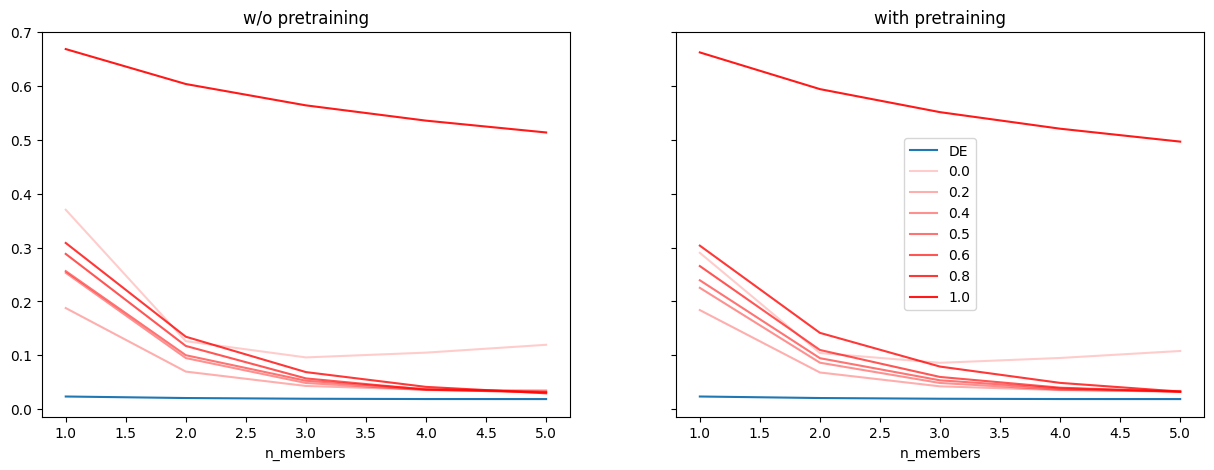

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharey=True)

agg_df["err"]["mean"].loc['ens_model_0', :].plot(ax=axes[0], label="DE")
agg_df["err"]["mean"].loc['ens_model_0', :].plot(ax=axes[1], label="DE")

alpha_plot = np.linspace(0.2, 0.9, len(ALPHAS))
for i, alpha in enumerate(ALPHAS):
    agg_df["err"]["mean"].loc[f'prod_model_0_{alpha}', :].plot(ax=axes[0], 
                                                               label=alpha, 
                                                               color="red", 
                                                               alpha=alpha_plot[i])
    agg_df["err"]["mean"].loc[f'prod_model_0_{alpha}_pretrained', :].plot(ax=axes[1], 
                                                                          label=alpha,
                                                                          color="red", 
                                                                          alpha=alpha_plot[i])
    
axes[0].set_title("w/o pretraining")
axes[1].set_title("with pretraining")
    
plt.legend()
plt.show()

In [28]:
fig = make_subplots(rows=1, cols=2, shared_yaxes=True, subplot_titles=("with pretraining", "w/o pretraining"))

fig.add_trace(
    go.Scatter(x=list(agg_df["err"]["mean"].loc['ens_model_0', :].index), 
               y=list(agg_df["err"]["mean"].loc['ens_model_0', :].values), 
               name="DE", marker = {'color' : 'blue'}),
    row=1, col=1,
)

fig.add_trace(
    go.Scatter(x=list(agg_df["err"]["mean"].loc['ens_model_0', :].index),
               y=list(agg_df["err"]["mean"].loc['ens_model_0', :].values),
               showlegend=False, name="DE", marker = {'color' : 'blue'}),
    row=1, col=2, 
)

alpha_plot = np.linspace(0.2, 0.9, len(ALPHAS))
for i, alpha in enumerate(ALPHAS):
    fig.add_trace(
    go.Scatter(x=list(agg_df["err"]["mean"].loc[f'prod_model_0_{alpha}', :].index), 
               y=list(agg_df["err"]["mean"].loc[f'prod_model_0_{alpha}', :].values), 
               name=alpha, marker = {'color' : 'red'}, opacity=alpha_plot[i]),
    row=1, col=1,
)

    fig.add_trace(
        go.Scatter(x=list(agg_df["err"]["mean"].loc[f'prod_model_0_{alpha}_pretrained', :].index),
                   y=list(agg_df["err"]["mean"].loc[f'prod_model_0_{alpha}_pretrained', :].values), 
                   name=alpha, marker = {'color' : 'red'}, showlegend=False, opacity=alpha_plot[i]),
        row=1, col=2, 
    )
    
fig.update_layout(height=600, width=1200)
fig.show()